# Structured hierarchical models

The goal of this project is to model essential genes for multiple conditions given that we have prior knowledge about functional relations of these genes. We extend the model from before to:

\begin{align}
\boldsymbol \pi & \sim \text{Dirichlet}(0.5, 0.5) \\
z_g & \sim \text{Categorical}(\boldsymbol \pi) \\
\tau^2 & \sim P(\cdot) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau^2) \\
\beta_{vg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau^2) \\
l_{vg} & \sim \text{Gamma}(1, 1) \\
x_{svg} \mid \beta_{vg} &  \sim \text{Pois}\left(l_{vg} \cdot \exp \left( \beta_{vg} \right) \right) \\
\end{align}

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [34]:
import pandas as pd
import numpy as np
import scipy as sp
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import edward2 as ed

In [3]:
from sklearn import preprocessing

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import arviz as az

sns.set_style(
    "white", 
    {'xtick.bottom': True,
     'ytick.left': True,
     'axes.spines.top': False, 
     'axes.spines.right': False})

## Simulated data

In [7]:
seed = 42
np.random.seed(seed)

In [8]:
conditions = ["C" + str(i) for i in range(2)]
genes = ["G" + str(i) for i in range(2)]
sgrnas = ["S" + str(i) for i in range(2)]
replicates = ["R" + str(i) for i in range(2)]

In [9]:
combinations = [(g, c, s, r) \
     for g in genes for c in conditions \
     for s in sgrnas for r in replicates]

In [33]:
combinations

[('G0', 'C0', 'S0', 'R0'),
 ('G0', 'C0', 'S0', 'R1'),
 ('G0', 'C0', 'S1', 'R0'),
 ('G0', 'C0', 'S1', 'R1'),
 ('G0', 'C1', 'S0', 'R0'),
 ('G0', 'C1', 'S0', 'R1'),
 ('G0', 'C1', 'S1', 'R0'),
 ('G0', 'C1', 'S1', 'R1'),
 ('G1', 'C0', 'S0', 'R0'),
 ('G1', 'C0', 'S0', 'R1'),
 ('G1', 'C0', 'S1', 'R0'),
 ('G1', 'C0', 'S1', 'R1'),
 ('G1', 'C1', 'S0', 'R0'),
 ('G1', 'C1', 'S0', 'R1'),
 ('G1', 'C1', 'S1', 'R0'),
 ('G1', 'C1', 'S1', 'R1')]

In [10]:
count_table = pd.DataFrame(
    combinations, 
    columns=["genes", "conditions", "sgrnas", "replicates"])

In [11]:
tau_true = sp.stats.halfcauchy.rvs(0, .1, size=1)
tau_true

array([0.06671342])

In [15]:
gamma_true = sp.array([.6, 6])
gamma_true

array([0.6, 6. ])

In [16]:
beta_true = sp.stats.norm.rvs(
    np.repeat(gamma_true, len(conditions)), tau_true)
beta_true

array([0.42570791, 0.66340242, 6.05446785, 5.89833701])

In [29]:
l_true = sp.stats.lognorm.rvs(
    1, size= len(conditions) * len(genes) * len(sgrnas))
l_true

array([0.58874613, 1.67074132, 1.10194583, 2.63437244, 0.49556681,
       0.72060644, 0.67563104, 0.23142141])

In [30]:
l_idx = np.repeat(range(len(l_true)), len(replicates))
l_idx

array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7])

In [32]:
beta_idx = np.repeat(range(len(beta_true)),
                     len(sgrnas) * len(replicates))
beta_idx

array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])

In [27]:
counts = sp.stats.poisson.rvs(
    l_true[l_idx] * np.exp(beta_true[beta_idx]))
counts

array([   1,    1,    1,    1,    0,    4,    1,    0,    0,    0,    4,
          3,   20,   30,    2,    1,  509,  470,  245,  265,  255,  213,
       1125, 1126,  489,  475,  215,  189,  121,  124,  343,  317])

## Model 1

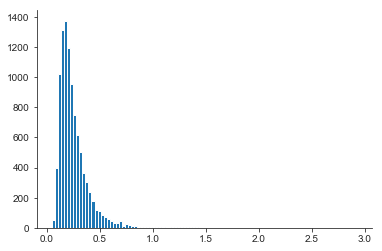

In [88]:
d = tfd.InverseGamma(5, 1).sample(10000)
with tf.Session() as sess:
    sample = sess.run(d)
plt.hist(sample, bins=100);

In [ ]:
def easy_model(data_dim,
               latent_dim, 
               num_datapoints, 
               stddv_datapoints):
    gamma_tau = ed.InverseGamma(10, 1, name="g_tau")
    gamma = ed.Normal(tf.zeros(len_g), gamma_tau, name="g")
    
    beta_tau = ed.InverseGamma(5, 1, name="b_tau")
    beta_f = ed.Normal(tf.zeros(len_beta), beta_tau, name="beta_f")
    beta = ed.Deterministic('beta', beta_tau * beta_f +  gamma)
    
      z = ed.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                    scale=tf.ones([latent_dim, num_datapoints]), 
                    name="z")  # parameter
      x = ed.Normal(loc=tf.matmul(w, z),
                    scale=stddv_datapoints * 
                    tf.ones([data_dim, num_datapoints]),
                    name="x")  # (modeled) data
      return x, (w, z)

log_joint = ed.make_log_joint_fn(probabilistic_pca)